In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier #0.76 acc score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from statistics import mean
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix

In [4]:
stop_words = pd.read_csv('stopwords.txt', sep=' ', header = None)[0]

# Returns a boolean value if the word given is a stop word
def is_a_stop_word(word):
    return word in stop_words.values
 
# Removes stop words from given text
def remove_stop_words(text):
    words = text.split()
    new_text = ""
    for word in words:
        if not is_a_stop_word(word):
            new_text = new_text + word + " "
    return new_text 

# Cleans a comment of different emojis, symbols, punctuation etc. and stop words
def clean_comments(comment, remove_sw = True):
    #first remove apostrphes commas signs...
    no_space_replacement = re.compile(r'[.\'<>,\"#)%(’‘–]')
    space_replacement = re.compile(r'/')
    #Then emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    clean_comment = no_space_replacement.sub('', comment)
    clean_comment = space_replacement.sub(' ', clean_comment)
    more_clean = emoji_pattern.sub(r'', clean_comment)
    if remove_sw:
        more_clean = remove_stop_words(more_clean.lower())
    return more_clean
    
#Have the labeled output in the last column
def reorganize_columns(df):
    original_col_list = list(df.columns)
    new_col_list = original_col_list[::-1]
    reorganized_df = df[new_col_list]
    return reorganized_df

#Deal with annotations... take the most common opinion.
def compact_annotations(annotation_list):
    most_common_annotations = list()
    
    for annotation in annotation_list:
        string = str(annotation)
        opinions = string.split('/')
        most_common_opinion = Counter(opinions).most_common(1)[0][0]
        most_common_annotations.append(most_common_opinion)
    
    return most_common_annotations

#Measure opinion agreement
def consensus(annot_list):
    agreement_rates = list()
    for annot in annot_list:
        opinion_count = Counter(annot).most_common(1)[0][1]
        rate = opinion_count/len(annot)

        #Which opinion is the most common, divide
        #by the total number of opinions and get the rate of the most common one
        #and if rate is 0.5, remove those rows
        
        if rate > 0.5:
        
            if Counter(annot).most_common(1)[0][0] == '1':
                agreement_rates.append(('pro-brexit', rate))
            elif Counter(annot).most_common(1)[0][0] == '0':
                agreement_rates.append(('anti-brexit', rate))
            else:
                agreement_rates.append(('non-cat', rate))
        
        else:
            
            agreement_rates.append(('contradicting', rate))
            
    return agreement_rates

#Remove comments (rows) with contradicting opinion
def remove_conflicts(data_frame):
    for row in data_frame.iterrows():
        annot = row[1]['Annotations'].split('/') 
        ctr = Counter(annot)
        #If mostly '-1'      DELETE
        #If same '0' and '1' DELETE
        #If 1/-1   or   0/-1 ?????
        if (ctr['0'] == ctr['1']) or (ctr.most_common(1)[0][0] == '-1'): #(ctr['0'] == ctr['-1']) or (ctr['1'] == ctr['-1']):
            # Drop the row from the dataframe, since the sentiment is not clear
            data_frame.drop(index=row[0], inplace=True)
        
    return data_frame

#Remove comments (rows) with contradicting opinion, also filters by rate
def remove_conflicts_by_rate(data_frame):
    for row in data_frame.iterrows():
        annot = row[1]['Annotations'].split('/') 
        ctr = Counter(annot)
        rate = ctr.most_common(1)[0][1]/len(annot)
        #If mostly '-1'      DELETE
        #If same '0' and '1' DELETE
        #If 1/-1   or   0/-1 ?????
        if (ctr['0'] == ctr['1']) or (ctr.most_common(1)[0][0] == '-1'): #(ctr['0'] == ctr['-1']) or (ctr['1'] == ctr['-1']):
            # Drop the row from the dataframe, since the sentiment is not clear
            data_frame.drop(index=row[0], inplace=True)
        elif rate < 0.6:
            # Drop the row if the majority is too small of a fraction
            data_frame.drop(index=row[0], inplace=True)
        
    return data_frame
    

In [5]:
#Read data
df = pd.read_csv('a2a_train_final.tsv', sep='\t', names = ["Annotations", "Comment"])
#df.head()
#Re-organize data
df = reorganize_columns(df)


Text(0.5, 1.0, 'Number of samples in different categories')

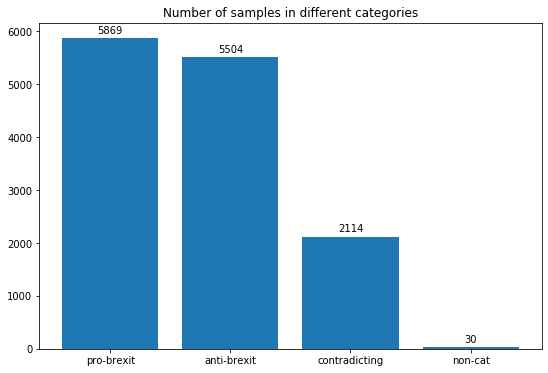

In [6]:

consensus_rate = consensus([str(annotation).split('/') for annotation in df['Annotations']])
x = [rate[0] for rate in consensus_rate]
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
bars = ax.bar(Counter(x).keys(), Counter(x).values())
for rect in bars:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
plt.title("Number of samples in different categories")


Text(0.5, 1.0, 'Number of labeled categories')

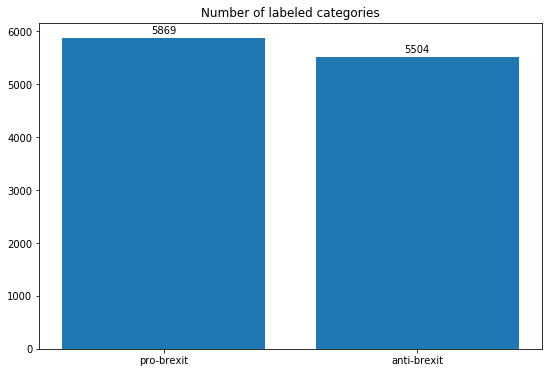

In [7]:
#Remove contradicting opinions
remove_conflicts_by_rate(df)

In [8]:
# Substitute the annotations with the most common one
annotations_compacted = compact_annotations(df['Annotations'])
df['Annotations'] = annotations_compacted

# Clean the comments, leave a dataframe with stop words still there
df_no_stop_words = pd.DataFrame.copy(df)
df_no_stop_words['Comment'] = df_no_stop_words['Comment'].apply(clean_comments, remove_sw=False)
df['Comment'] = df['Comment'].apply(clean_comments)

# Copy of the main dataframe for other vectorizer, I (Mihkel) added my own approach on top so I copyd
# the datagframe just in case
df_2 = pd.DataFrame.copy(df)

In [9]:
ct_vec = CountVectorizer()
x = df["Comment"]
y = df["Annotations"]

#Split the data
xtrain, xtest, ytrain, ytest = train_test_split(x,y)

In [10]:
# Apply CountVectorizer

xtrain_counts = ct_vec.fit_transform(xtrain)
clf = MultinomialNB()
clf.fit(xtrain_counts, ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
# Accuracy and F1 score of the MNB classifier

xtest_transformed = ct_vec.transform(xtest)
yguess = clf.predict(xtest_transformed)
accuracy_score(y_true=ytest, y_pred= yguess)
f1_score(ytest, yguess)

In [34]:
# Split the data into training and test set.
X_train, X_eval, Y_train, Y_eval = train_test_split(df_2['Comment'], df_2['Annotations'], test_size=0.2, random_state=12345)
X_with_stop_words, x_eval_stop, y_train_stop, y_eval_stop = train_test_split(df_no_stop_words['Comment'], df_no_stop_words['Annotations'], test_size=0.2, random_state=12345)

# A pipeline that used TfidfVectorizer
def train_document_classifier(X, Y, classifier):
    pipeline = make_pipeline( TfidfVectorizer(), classifier)
    pipeline.fit(X, Y)
    return pipeline

# Returns the Accuracy and F1 score of the given classifier
def acc_and_f1_score_of_classifier(X, Y, X_test, Y_test, classifier):
    trained_clf = train_document_classifier(X, Y, classifier)
    return accuracy_score(Y_test, trained_clf.predict(X_test)), f1_score(Y_test, trained_clf.predict(X_test), pos_label='1')

In [30]:
# Trying different models 

print(acc_and_f1_score_of_classifier(X_train, Y_train, X_eval, Y_eval,LinearSVC()))
log_reg_clf = LogisticRegression()
print(acc_and_f1_score_of_classifier(X_train, Y_train, X_eval, Y_eval,log_reg_clf))
print(acc_and_f1_score_of_classifier(X_train, Y_train, X_eval, Y_eval,RandomForestClassifier(n_jobs=-1, max_depth=50, n_estimators=1000)))
mlp_clf = MLPClassifier(hidden_layer_sizes=(150, 50, 30), learning_rate='adaptive', max_iter=300)
print(acc_and_f1_score_of_classifier(X_train, Y_train, X_eval, Y_eval,mlp_clf))
clf_base = AdaBoostClassifier(n_estimators=2000)
print(acc_and_f1_score_of_classifier(X_train, Y_train, X_eval, Y_eval,clf_base))

(0.792967032967033, 0.7954841511072515)
(0.7956043956043956, 0.7954245490541134)
(0.76, 0.7705882352941177)
(0.7718681318681319, 0.7726675427069645)
(0.7406593406593407, 0.7434782608695651)


In [31]:
print(acc_and_f1_score_of_classifier(X_train, Y_train, X_eval, Y_eval,MultinomialNB()))

(0.7815384615384615, 0.7957254418413482)


In [35]:
# Log boost had the best results on the test set, so I also look at cross validation
clf = train_document_classifier(X_train, Y_train, log_reg_clf)
scores = cross_val_score(clf, X_eval, Y_eval, cv=5)

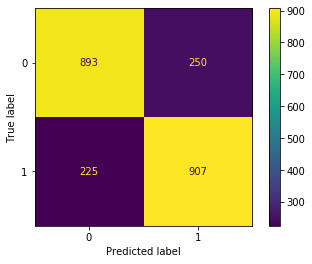

In [36]:
# Get the confusion matrix as well as print out every 10th sentence that the labeling got wrong
# The sentence is printed out with and without stop words
log_pipe = train_document_classifier(X_train, Y_train, LogisticRegression())
plot_confusion_matrix(log_pipe, X_eval, Y_eval, values_format='n')

In [37]:
Y_pred = log_pipe.predict(X_eval)
count = 0
for i in range(len(Y_pred)):
    if Y_pred[i] != Y_eval.iloc[i]:
        count += 1
        if count == 10:
            print(x_eval_stop.iloc[i])
            print(X_eval.iloc[i])
    count = count % 10

Sometimes in life you need to take a risk
life risk 
Those who voted for leave will cry the most in the future
voted leave cry future 
How is leaving the EU a Bad thing?
leaving eu bad thing? 
Its interesting to hear Leavers proclaiming that we are now freed from the EU shackles yet fail to understand that the UK is now in vassalage to the EU for the rest of the year and possibly longer!
interesting hear leavers proclaiming freed eu shackles fail understand uk vassalage eu rest year possibly longer! 
If they wanted to leave EU thats ok but Brits should be greatful to be part of EU without it they would be much much poorer now
wanted leave eu brits greatful part eu poorer 
Im not saying businesses are bad we NEED businesses and traid I just dont want BP passing legislations for us The UK used to produce a lot of stuff so we exported loads now we import more then we sell Outside the EU wed have better trading prospects It wont be free traid But there will be more options
businesses bad b

In [38]:
# Just in case tried it with stop words still in the datset, turns out it has better results
# I also retried all the models previously with the datset with stop words and LogReg was still the best
acc_and_f1_score_of_classifier(X_with_stop_words, y_train_stop, x_eval_stop, y_eval_stop, LogisticRegression())

(0.7956043956043956, 0.7954245490541134)